#Tracking Lost Particles

My diagnostics do not have the capability to track lost particles properly. This is an issue not only because I can't properly identify non-closed particle orbits and large amplitude excursions, it also means that I cannot seemeless plot outputs for which the particle number drops, as I am allocating different size arrays and stacking them.

1. One way to sort this out is to add a 'lost' flag to the array, which is evaluted for each particle at each output step. Thus, each time an .h5 file is read in, the particles are marked as present (True), or lost (False). This value must be specified for each particle at each step.
    - Pros: Simple and fast construction. I do not need to impose any additional structure to the storage of particles.
    - Cons: Inefficient plotting/output - All of the information is stored in one complicated array which must be parsed when separating out present and lost particles. Thus, all of my scripts must be updated to include a line which passes only the present particles to be plotted...
    
2. An alternative solution is to split the present and lost particles into two different arrays. Each array will be updated to reflect the most recently read .h5 file. Thus, after each output step the particles array and lost array is updated.
    - Pros: Fast plotting/output. Complete separation makes plottting the two components of a bunch fast and easy. Future diagnostics looking at beam halo and bunch loss may be improved by having these items managed separately.
    - Cons: Inefficient construction. Array sizes are constantly changed/re-allocated to maintain consistency between the current and lost particles.
    
    
As a test case, I will consider the 3rd Order simulation of my test lattice with a large beam which loses 1 particle in the first 400 turns. Obviously the script should account for an arbitrary # of lost particles.

In [1]:
%load_ext watermark
%load_ext autoreload
%autoreload 2

In [2]:
%watermark -d -v -a "Nathan Cook"

Nathan Cook 23/07/2015 

CPython 2.7.10
IPython 3.1.0


In [3]:
import sys
import synergia
from mpi4py import MPI
import synergia_workflow

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
## Quickly construct lattice simulator

from base_diagnostics import workflow
from base_diagnostics import latticework

#load lattice
lattice = synergia.lattice.Mad8_reader().get_lattice("model16s", "/Users/ncook/Synergia_Tests/lattices/foborodobo_NL.lat")

length = lattice.get_length()
ref = lattice.get_reference_particle() #reference particle
ds = 0.01
nsteps = int(length/ds) +1 #calculate # of steps to take per turn
nsteps_per_element = nsteps/len(lattice.get_elements()) #not this isn't using future division, so returns int

name = 'model-S-strong-large2'
order = 3
outputdir = 'order_'+str(order)+'_'+name

opts = workflow.make_opts(name, order, outputdir, nsteps, nsteps_per_element)
lattice_simulator = synergia.simulation.Lattice_simulator(lattice,
                                                              opts.map_order)
stepper= synergia.simulation.Independent_stepper(lattice, opts.map_order, opts.steps)

#define a secondary lattice_simulator for this work

#stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
new_lattice_simulator = stepper.get_lattice_simulator()

x_tune0, y_tune0 = new_lattice_simulator.get_both_tunes()
x_tune1 = 0.33 #place on resonance
y_tune1 = y_tune0 #keep the same if possible
tune_tol = 1.0e-7; #need to define a tolerance for the fit


#specify a set of magnets to be adjusted
f_quads, d_quads = latticework.get_fd_quads(lattice)

#use these magnets to adjust tune to specified final values
new_lattice_simulator.adjust_tunes(x_tune1,y_tune1,f_quads,d_quads,tune_tol)

#update lattice_simulator and get new lattice
new_lattice_simulator.update()
new_lattice = new_lattice_simulator.get_lattice()

#Force define original lattice simulator
lattice = synergia.lattice.Mad8_reader().get_lattice("model16s", "/Users/ncook/Synergia_Tests/lattices/foborodobo_NL.lat")
stepper = synergia.simulation.Independent_stepper_elements(lattice, opts.map_order, opts.steps_per_element)
lattice_simulator = stepper.get_lattice_simulator()


#Print stuff for original lattice
print str(lattice_simulator.get_horizontal_tune()) + " is the original x-tune"
f_quads, d_quads = latticework.get_fd_quads(lattice)
latticework.print_strengths(f_quads)
latticework.print_strengths(d_quads)

#Print stuff for new re-tuned lattice
print str(new_lattice_simulator.get_horizontal_tune()) + " is the new x-tune"
new_f_quads, new_d_quads = latticework.get_fd_quads(new_lattice)
latticework.print_strengths(new_f_quads)
latticework.print_strengths(new_d_quads)


0.0920106680371 is the original x-tune
f K: 0.714285714286
d K: -0.714285714286
0.329999998897 is the new x-tune
f K: 0.761214567067
d K: -0.729172681136


In [5]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16-S 3rd Integer'
popts.ID = None
popts.path = None
popts.turns = opts.turns
popts.norm = False
popts.save = False
popts.variance = 0.1
popts.lattice_simulator = new_lattice_simulator
popts.relpath = 'order_3_model-S-strong-large2'

#singleparticle.plot_Invariant(popts)

In [6]:
files = singleparticle.get_file_list(popts)
fileName = files[240]
inputfile = fileName
header, particles = singleparticle.get_particles(inputfile)
twiss = singleparticle.get_twiss(popts.lattice_simulator)
norm_coords = singleparticle.normalized_coordinates(header, particles, twiss)

In [7]:
npart = particles.shape[0]
if (particles[:,6] == np.asarray(range(npart))).all():
    print 'yes'
else:
    print 'no'

no


In [8]:
boolVals = (particles[:,6] == np.asarray(range(npart)))
list(boolVals).index(False)

28

In [12]:
header1, particles1 = singleparticle.get_particles(files[0])

header2, particles2 = singleparticle.get_particles(files[240])

In [17]:
particles1[:,6].size

200

In [19]:
boolVals = (particles1[0:particles2[:,6].size,6] == particles2[:,6])

In [21]:
boolVals[28]

False

In [25]:
#first check if size is equal
if not (header1['n_part'] == header2['n_part']):
    #make a boolean comparison
    boolVals = (particles1[0:header2['n_part'],6] == particles2[:,6])
    #non-equal values refer to lost particles - return index of 'False' to get lost particle
    lost = list(boolVals).index(False)
    print lost

28


In [54]:
def get_lost_particle_list(opts):
    '''Returns a list of particle IDs corresponding to lost particles from inspection of the output files'''
    files = singleparticle.get_file_list(opts)
    
    #compare first file output to final file output
    header1, particles1 = singleparticle.get_particles(files[0])
    
    header2, particles2 = singleparticle.get_particles(files[-1])
    
    lost = []
    
    #first check if size is equal
    if not (header1['n_part'] == header2['n_part']):
        #make a boolean comparison
        boolVals = (particles1[0:header2['n_part'],6] == particles2[:,6])
        #non-equal values refer to lost particles - return index of 'False' to get lost particle
        lost = list(boolVals).index(False)
    
    #if only one particle is lost, then we have an int and not a list, so we want to cast as a list
    if type(lost) == int:
        return [lost]
    else: 
        return lost

In [53]:
lost = get_lost_particle_list(popts)
print lost
print len(lost)

[28]
1


If we can construct a lost particle list beforehand, then we can simply place particles with 'lost' IDs into a separate array as we go.

In [30]:
import tables
inputfile = files[0]
f = tables.openFile(inputfile, 'r')
particles = f.root.particles.read()
f.close()

Now we will adjust the `get_particles` method to return the lost particles and kept particles arrays. The array sizes should be consistent throughout the entire analysis, as any particle which is eventually lost will be placed in the lost array from the start.

In [123]:
def get_particles(inputfile, lost=None):
    
    '''Reads an input file and returns a numpy array of particles and a dictionary of root values. 
    If lost particles specified, then returns those separately.
    
    '''
    
    f = tables.openFile(inputfile, 'r')
    particles = f.root.particles.read()
    
    #As a test, arbitrarily remove some particles - working as intended
    #particles = np.delete(particles,10,0)
    #lost.append(10)
    #particles = np.delete(particles,20,0)
    #lost.append(21)
    
    #define lost particles array
    #lost_particles = np.zeros((len(lost),7))
    #lost_particles[:,6] = lost
    
    #get appropriate reference properties from file root
    npart = particles.shape[0]
    mass = f.root.mass[()]
    p_ref = f.root.pz[()]
    sn = f.root.s_n[()] #period length
    tn = f.root.tlen[()] #cumulative tracked length for this file

    f.close()
    
    header = dict()
    header['n_part'] = npart
    header['mass'] = mass
    header['p_ref'] = p_ref
    header['s_val'] = sn
    header['t_len'] = tn
    
    if lost:
    
        #define new lists
        lost_particles = []
        kept_particles = []
        #we want to create a copy to operate on
        lost_counter = list(lost)
    
        #separate lost particles
        for index,particle in enumerate(particles):
            if particle[6] in lost:
                lost_particles.append(particle)
                #remove from counter
                lost_counter.remove(particle[6])
            else:
                kept_particles.append(particle)
            
        #now we just need to make sure we fill out the kept_particles array to make it the proper length.
        if not len(lost_particles) == len(lost):
            for num in lost_counter:
                placeholder = [-1,-1,-1,-1,-1,-1,num]
                lost_particles.append(placeholder)
    
        return header, np.asarray(kept_particles), np.asarray(lost_particles)
    
    else:
        
        return header, particles

In [109]:
lost = get_lost_particle_list(popts)
h, new_p, lost_p = get_particles(files[0],lost)

In [110]:
lost_p

array([[  2.55832326e-02,   4.21104528e-04,   1.38477405e-02,
         -1.44500962e-03,   1.74656881e+01,   0.00000000e+00,
          2.80000000e+01],
       [ -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
         -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
          1.00000000e+01],
       [ -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
         -1.00000000e+00,  -1.00000000e+00,  -1.00000000e+00,
          2.10000000e+01]])

Now that this adjusted function seems to be working, we will try it out on a sequence of output files.

In [128]:
files = singleparticle.get_file_list(popts)
#fileName = files[240]
#inputfile = fileName
#get lost particle list
lost = get_lost_particle_list(popts)
#header, particles, lost_particles = singleparticle.get_particles(inputfile, lost)
twiss = singleparticle.get_twiss(popts.lattice_simulator)
pArray = singleparticle.get_normalized_coords(files,twiss,lost)
#norm_coords = singleparticle.normalized_coordinates(header, particles, twiss)

In [129]:
pArray.shape

(401, 199, 4)

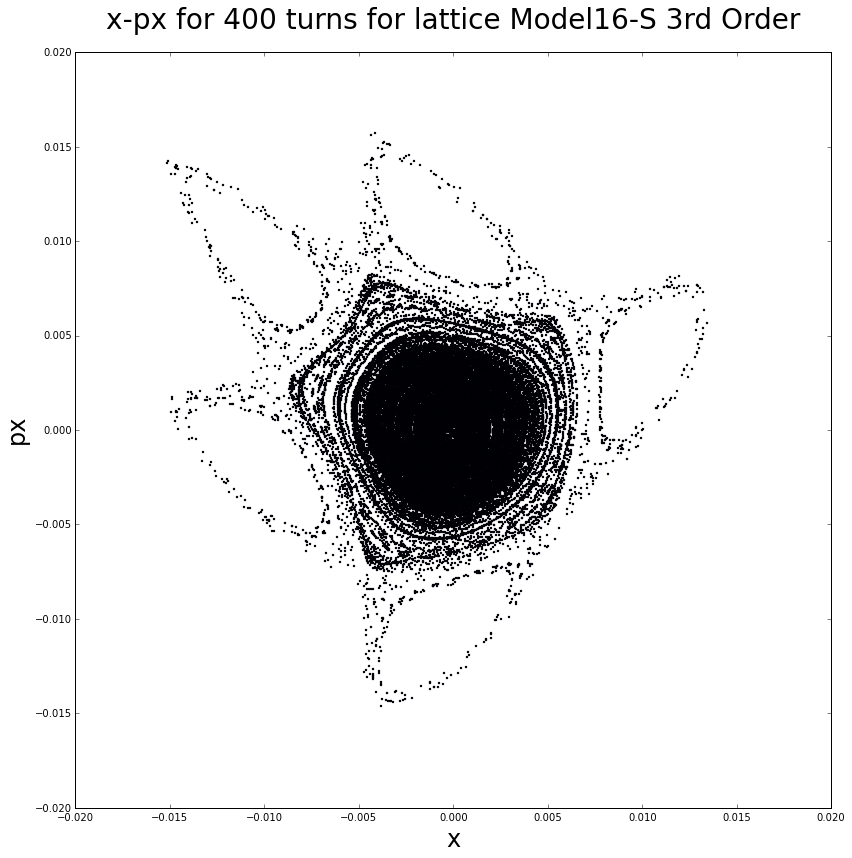

In [142]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16-S 3rd Order'
popts.ID = None
popts.path = None
popts.turns = 400 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = new_lattice_simulator
popts.relpath = opts.output_dir

popts.save = False
popts.plots = ['x','px']
popts.num = 150
popts.scale = 2

popts.hcoord = popts.plots[0]
popts.vcoord = popts.plots[1]

singleparticle.plot_P(pArray, popts, num=10, ID=0)

##Plotting the lost particles

Oftentimes we will want to specifically plot the particles which we lost. With this setup, we can do so without too much trouble. I've introduced another option attribute called "plot_lost", which when specified, allows one to plot the particles which were classified as lost. Recall that the placeholder value for particle coordinates is the 0-vector, and thus for all outputs after the particle is lost, the particles are plotted at the origin. This should be acceptable, given that our interest in plotting lost particles is looking at their large excursions, not at near-origin behavior.

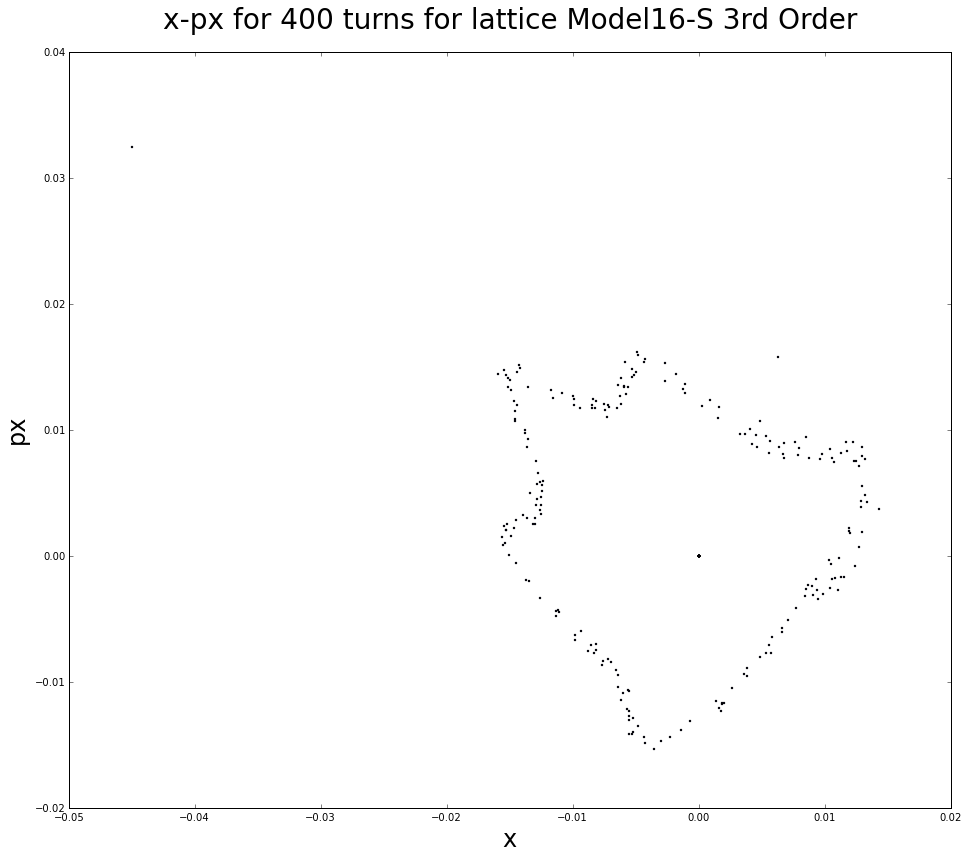

In [148]:
from base_diagnostics import options
from base_diagnostics import singleparticle

popts = options.Options()
popts.lattice_name = 'Model16-S 3rd Order'
popts.ID = None
popts.path = None
popts.turns = 400 
popts.norm = False
popts.save = True
popts.variance = 0.01
popts.lattice_simulator = new_lattice_simulator
popts.relpath = opts.output_dir

popts.save = False
popts.plots = ['x','px']
popts.num = 150
popts.scale = 2
popts.plot_lost = True

popts.hcoord = popts.plots[0]
popts.vcoord = popts.plots[1]

singleparticle.plot_Poincare(popts)